Convert origami crease pattern folding image into an image sutable for laser etching to etch the paper before performing the folds. The idea is to do this step instead of pre-creasing the paper by hand.

crease pattern folding is explored by [Robert J. Lang](https://langorigami.com/crease-patterns/). I tunned this notebook to work with his images and the [images](https://www.flickr.com/photos/156686586@N07/sets/72157711291668357/) that follow this [YouTube series by OrigamiByBoice](https://www.youtube.com/watch?v=slpw01Vpg3U&list=PLT_uBKzl3wcczX-YpbB7b_DMK4TAgtV20) on how to fold the patterned origami paper.

In [1]:
# download an example
# To get a link to a flickr image hover your mouse over the download button at the bottom right
# right click and Copy Link then open a new borwser tab and paste the link
# hover over the image and Copy Image Address and paste it in the curl command below...
!curl https://live.staticflickr.com/65535/48988517087_685ed7ee89_o.jpg --output ./images/input.jpg
#!curl https://langorigami.com/wp-content/uploads/2018/11/Elliptic_Infinity_A_50_cp.jpg  --output ./images/input.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 86567  100 86567    0     0   503k      0 --:--:-- --:--:-- --:--:--  506k


In [2]:
import numpy as np
import cv2
import math
from matplotlib import pyplot as plt

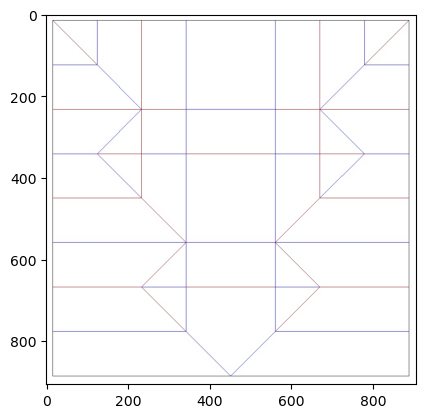

(906, 907, 3)

In [3]:
imgcolor = cv2.imread('images/input.jpg')
plt.imshow(imgcolor)
plt.show()
imgcolor.shape

truncate to a square

In [4]:
# truncate to a square
w,h,c = imgcolor.shape
if w < h:
    imgcolor = imgcolor[:,:w,:]
elif w > h:
    imgcolor = imgcolor[:h,:,:]
w,h,c = imgcolor.shape

In [5]:
# identify which RGB values are used
d = {}
for x in range(w):
    for y in range(w):
        c = ((imgcolor[x,y,0]+5)//10,(imgcolor[x,y,1]+5)//10,(imgcolor[x,y,2]+5)//10)
        if c in d:
            d[c] += 1
        else:
            d[c] = 1
l = [(c,v) for (c,v) in d.items() if min(c) < 10]
l.sort(key = lambda cv: -cv[1])
l[:10]

[((0, 0, 0), 3383),
 ((5, 5, 14), 3258),
 ((11, 2, 2), 1491),
 ((12, 2, 2), 1480),
 ((5, 5, 15), 971),
 ((6, 6, 12), 403),
 ((5, 5, 13), 314),
 ((8, 2, 2), 282),
 ((10, 2, 2), 265),
 ((8, 2, 3), 94)]

In [6]:
#https://stackoverflow.com/questions/45322630/how-to-detect-lines-in-opencv
def getchan(imgcolor,rgb = [0,0,0],dif=0,maxc=-1):
    
    
    mask = np.zeros(imgcolor.shape[:-1],np.uint8)
    for x in range(imgcolor.shape[0]):
        for y in range(imgcolor.shape[1]):
            px = imgcolor[x,y,:]
            if maxc >= 0 and maxc != np.argmax(px):
                continue
            if dif > 0 and max(px) - min(px) < dif:
                continue
            if dif < 0 and max(px) - min(px) > -dif:
                continue
            f = True
            for c,t in enumerate(rgb):
                if t > 0 and px[c] < t:
                    f = False
                    break
                if t < 0 and px[c] > -t:
                    f = False
                    break
            if f:
                mask[x,y] = 255

    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
#     kernel_size = 5
#     mask = cv2.GaussianBlur(mask,(kernel_size, kernel_size),0)

    n = 4
    for i in range(n):
        mask = cv2.dilate(mask,kernel)
    for i in range(n):
        mask = cv2.erode(mask,kernel)
    mask = cv2.Canny(mask,200,250)
    
    n = 4
    for i in range(n):
        mask = cv2.dilate(mask,kernel)
    for i in range(n):
        mask = cv2.erode(mask,kernel)
    
    return mask

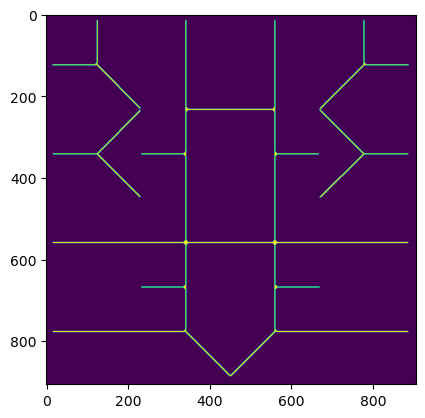

In [7]:
imgB = getchan(imgcolor, rgb = [-140,-140,70],dif = 20,maxc=2)
plt.imshow(imgB) #, interpolation='nearest')
plt.show()

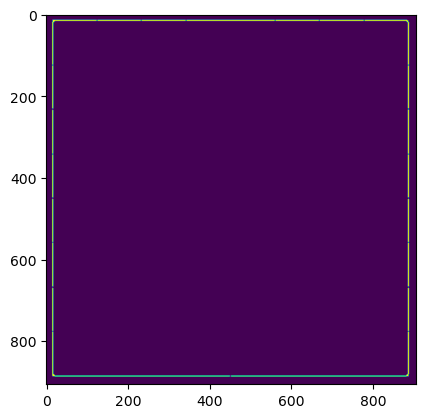

In [8]:
imgC = getchan(imgcolor,rgb = [-140,-140,-140], dif = -20)
plt.imshow(imgC) #, interpolation='nearest')
plt.show()

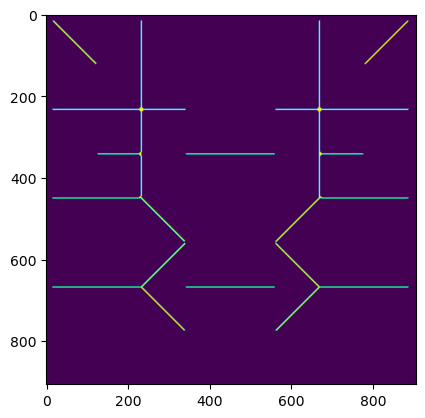

In [9]:
imgR = getchan(imgcolor, rgb = [40,-140,-140],dif = 20,maxc=0)
plt.imshow(imgR) #, interpolation='nearest')
plt.show()

In [10]:
# identify lines in an image and plot them in an output image
def plot(img,output,w=1,dashblack=0,dashwhite=0,c=(0,0,0)):
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 40  # angular resolution in radians of the Hough grid
    threshold = 12  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10  # minimum number of pixels making up a line
    max_line_gap = 30  # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)
#     lsd = cv2.createLineSegmentDetector(0)
#     lines = lsd.detect(img)[0]
    dash = dashblack + dashwhite

    for polygon in lines:

#         print(polygon)

        # draw polygon lines
        for idx, (x1,y1,x2,y2) in enumerate(polygon):
            if x1 > x2:
                x1,x2 = x2,x1
                y1,y2 = y2,y1
            if dash:
                l = math.sqrt((x2-x1)**2 + (y2-y1)**2)
                n = l/dash
                dx = (x2-x1)/n
                ddx = dx * dashblack/dash
                dy = (y2-y1)/n
                ddy = dy * dashblack/dash
                n = int(n)
                for i in range(n):
                    xx1 = int(x1 + dx * i + 0.5)
                    xx2 = int(x1 + dx * i + ddx + 0.5)
                    yy1 = int(y1 + dy * i + 0.5)
                    yy2 = int(y1 + dy * i + ddy + 0.5)                    
                    output = cv2.line(output, (xx1, yy1), (xx2, yy2), c, w)
            else:
                output = cv2.line(output, (int(x1+0.5), int(y1+0.5)), (int(x2+0.5), int(y2+0.5)), c, w)
    return output

In [11]:
output = np.ones(imgcolor.shape, np.uint8)*255

In [12]:
output = plot(imgR, output,w=1,dashblack=2,dashwhite=8)

In [13]:
output = plot(imgC, output, w=4)

In [14]:
output = plot(imgB, output,w=1,dashblack=2,dashwhite=2)

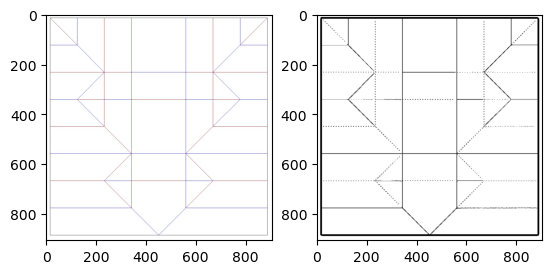

In [15]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(imgcolor)
axarr[1].imshow(output)
#plt.imshow(output) #, interpolation='nearest')
#plt.show()

In [16]:
cv2.imwrite('images/output.png',output)

True

I used the output images of this notebook to etch the paper using Creality Laser kit for Ender 3 S1.
My origami paper is 150mm x 150mm.
I open the image in Creality Print and scale the image to 145mm x 145mm and move it to 75mm x 75mm,
decreased Power Rate to 40% and increase Work Speed to 3000mm/min. It takes about an hour for ther laser to scan the entire paper surface.